In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# 1. Dataset Path Setup
import os
base_path = '/content/drive/MyDrive/MainDataset'
train_dir = os.path.join(base_path, 'Train')
val_dir = os.path.join(base_path, 'Test')
test_dir = os.path.join(base_path, 'Validation')

print("Train folders:", os.listdir(train_dir))


Train folders: ['black_sigatoka', 'potassium_deficiency', 'panama_disease', 'healthy', 'yellow_sigatoka']


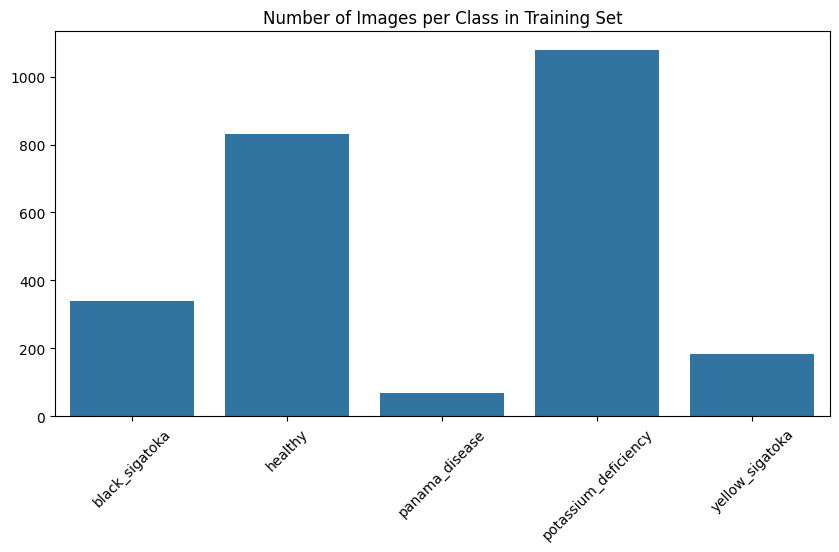

In [ ]:
# 2. Visualization of Classes
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = pathlib.Path(train_dir)
class_names = sorted(item.name for item in data_dir.glob("*/") if item.is_dir())
class_counts = {cls: len(list(data_dir.glob(f"{cls}/*.jpg"))) for cls in class_names}

plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.title("Number of Images per Class in Training Set")
plt.show()



In [ ]:
# 3. Data Generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=30, zoom_range=0.2, horizontal_flip=True,
    width_shift_range=0.1, height_shift_range=0.1)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
val_data = val_datagen.flow_from_directory(
    val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
test_data = test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)


Found 2504 images belonging to 5 classes.
Found 539 images belonging to 5 classes.
Found 573 images belonging to 5 classes.


In [ ]:
# 4. EfficientNetB0 Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def build_efficientnet_model(learning_rate=0.0001, dropout_rate=0.3):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(len(class_names), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_efficientnet_model()
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 103s 6s/step
                      precision    recall  f1-score   support

      black_sigatoka       0.00      0.00      0.00        71
             healthy       0.00      0.00      0.00       227
      panama_disease       0.00      0.00      0.00        17
potassium_deficiency       0.39      1.00      0.56       222
     yellow_sigatoka       0.00      0.00      0.00        36

            accuracy                           0.39       573
           macro avg       0.08      0.20      0.11       573
        weighted avg       0.15      0.39      0.22       573



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


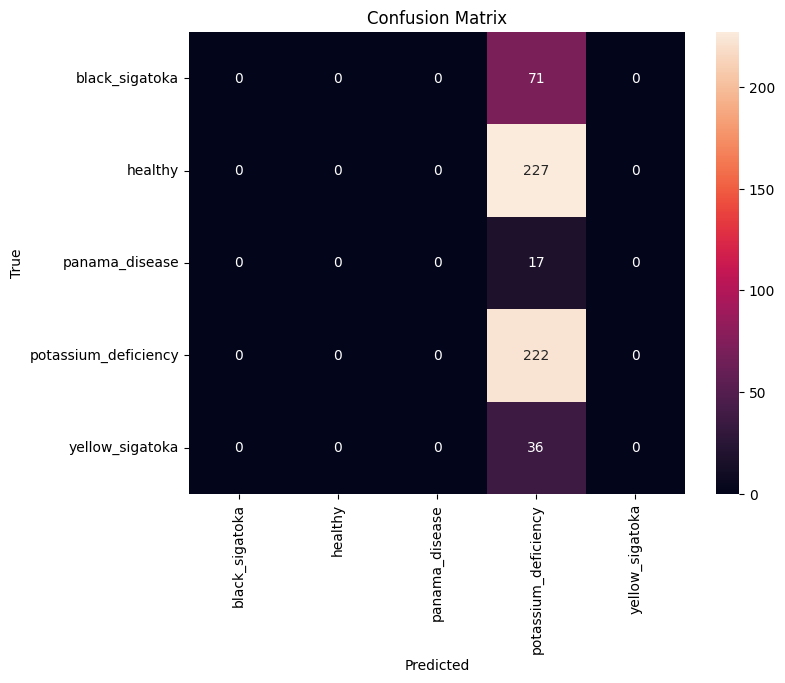

In [ ]:
# 5. Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

pred = model.predict(test_data)
y_pred = np.argmax(pred, axis=1)
y_true = test_data.classes

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
!ls


drive  sample_data


In [ ]:
# 6. Inference on Uploaded Images (EfficientNet)
from tensorflow.keras.models import load_model
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define image size (should match training input size)
IMG_SIZE = 224  # or 160/128/etc. depending on your EfficientNet version

# Define class names in order of training labels
# Example: class_names = ['Cat', 'Dog', 'Elephant']
class_names = ['Class1', 'Class2', 'Class3']  # <-- Replace with your actual class names

# Load the trained model
model = load_model('best_efficientnet_model.h5')

# Upload image(s) for inference
uploaded = files.upload()

# Loop through each uploaded image and make predictions
for img_path in uploaded.keys():
    # Load and preprocess image
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE)).convert('RGB')
    img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

    # Predict
    pred = model.predict(img_array)
    predicted_class = class_names[np.argmax(pred)]
    confidence = np.max(pred) * 100

    # Show result
    print(f"\nPredicted Class: {predicted_class} ({confidence:.2f}%)")
    plt.imshow(img)
    plt.title(f"{predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'best_efficientnet_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)